In [2]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import random

/home/ubuntu/PycharmProjects/adds-early-burnout-warning-model/venv/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
from sqlalchemy import create_engine, text

def postgresql_engine(user, pwd, host, port, dbname):
    # Need psycopg2-binary package
    sql_engine = create_engine('postgres://' + user + ':' + pwd + '@' + host + ':' + port + '/' + dbname, echo=False)
    return sql_engine

In [4]:
# DB username & password
import getpass

username = getpass.getpass()
password = getpass.getpass()

In [5]:
# misc db parameters
url= 'adds-postgres-dev.cfgztrijqgvp.us-east-1.rds.amazonaws.com'
database= 'musiclab'
port= '5432'

In [6]:
data_query = '''
Select *
from adds_temp.ebw_metric_analysis as ema
'''

In [7]:
engine = postgresql_engine(username, password, url, port, database)
with engine.connect() as conn:
    with conn.begin():
        df_ebw_metrics = pd.read_sql(data_query, con=conn)

In [8]:
len(df_ebw_metrics)

2354683

In [9]:
df_ebw_metrics.drop_duplicates(inplace=True)

In [10]:
df_ebw_metrics.head()

,week_dt,mediabase_id,song_id,call_letters,format_code,song_release_date,last_callout_date,first_spin_date,StartDate,EndDate,...,gcr,gcr_adj,station_id,cmm_station_calls,test_date,breakout_respondents,pop,fav_metric,ddl_metric,f2b_ratio
0,2018-10-01,2356990,290730733,WMIB-FM,U1,2018-10-01,2019-01-14,2018-10-08,2018-09-30,2018-10-06,...,None,None,3322924.0,WMIB-FM,2018-10-01,90.0,73.0,20.0,6.0,3.33
1,2018-10-01,2436027,544577900,WPGB-FM,C1,2018-10-01,2021-03-22,2018-10-08,NaT,NaT,...,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN
2,2018-10-01,2436027,544577900,WSIX-FM,C1,2018-10-01,2021-03-01,2018-10-08,NaT,NaT,...,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN
3,2018-10-01,2436027,544577900,WUBL-FM,C1,2018-10-01,2020-10-12,2018-10-08,NaT,NaT,...,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN
4,2018-10-01,2436027,544577900,WPOC-FM,C1,2018-10-01,2021-08-30,2018-10-08,NaT,NaT,...,None,None,NaN,None,None,NaN,NaN,NaN,NaN,NaN


In [11]:
# song-artist lookup
song_query = '''
Select mediabase_id, song_name, artist_name
from data.songs_v as sv
'''
engine = postgresql_engine(username, password, url, port, database)
with engine.connect() as conn:
    with conn.begin():
        df_song_lookup = pd.read_sql(song_query, con=conn)

In [12]:
df_song_lookup.set_index(['mediabase_id'], inplace=True)

In [13]:
df_song_lookup.head()

,song_name,artist_name
mediabase_id,,
1178830,Thorazine Shuffle,GOV'T MULE
1906303,Be Mine,JESSICA BREANNE/ELEC. HEARTS
1114516,Odorono,WHO
1175101,One Day You'll Be Mine,USHER
2849810,Takin' Care Of Business (Live),ALABAMA


In [14]:
# extract all formats
all_formats = list(pd.unique(df_ebw_metrics['format_code']))
all_formats.sort()
all_formats

['A1', 'A2', 'C1', 'H1', 'L1', 'L3', 'O1', 'R1', 'R2', 'R3', 'U1', 'U2', 'Y0']

In [15]:
# define major formats
major_formats = ['C1', 'H1', 'U1']

#### Unique songs

In [16]:
df_ebw_metrics.groupby(['format_code']).apply(lambda x:(len(pd.unique(x['mediabase_id'])), len(pd.unique(x['station_id']))))

format_code
A1     (92, 10)
A2     (272, 9)
C1    (273, 19)
H1    (453, 33)
L1     (263, 5)
L3      (87, 3)
O1      (29, 2)
R1     (160, 2)
R2     (128, 6)
R3     (253, 9)
U1    (499, 17)
U2     (133, 4)
Y0     (366, 7)
dtype: object

#### Unique songs and stations

In [17]:
df_ebw_metrics.groupby(['format_code']).apply(lambda x:len((x[['mediabase_id', 'station_id']].drop_duplicates())))

format_code
A1     490
A2    1149
C1    3409
H1    7260
L1     818
L3     229
O1      58
R1     319
R2     496
R3     969
U1    3125
U2     417
Y0    1390
dtype: int64

### Analyze Favorite, DDL and F2B ratio

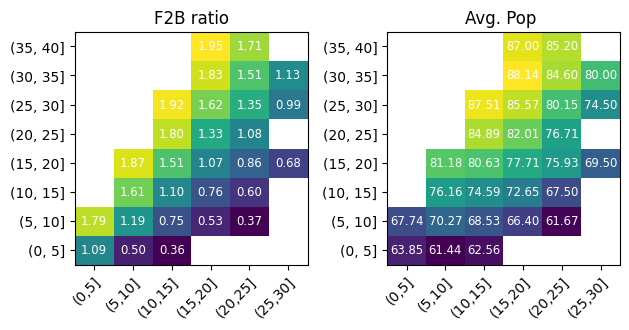

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
pd.options.mode.chained_assignment = None  # default='warn'

# plot out favorite, f2b ratio, and pop scoress
for fmt in major_formats:
    df_temp = df_ebw_metrics[(df_ebw_metrics['format_code']==fmt) & (~pd.isna(df_ebw_metrics['pop'])) & (df_ebw_metrics['f2b_ratio']<=2)]

    # Discretize DDL and F2B
    df_temp.loc[:, 'fav_bucket'] = pd.cut(df_temp['fav_metric'], bins=pd.interval_range(start=0, end=40, freq=5))
    df_temp.loc[:, 'ddl_bucket'] = pd.cut(df_temp['ddl_metric'], bins=pd.interval_range(start=0, end=40, freq=5))

    df_temp_agg_f2b = pd.pivot_table(df_temp.groupby(['ddl_bucket', 'fav_bucket']).agg({'f2b_ratio': np.mean}).reset_index(), index = ['fav_bucket'], columns=['ddl_bucket'])
    df_temp_agg_pop = pd.pivot_table(df_temp.groupby(['ddl_bucket', 'fav_bucket']).agg({'pop': np.mean}).reset_index(), index = ['fav_bucket'], columns=['ddl_bucket'])

    # print(df_temp_agg_f2b)
    ax1 = plt.subplot(1,2,1)
    im = ax1.imshow(df_temp_agg_f2b, origin='lower')

    # Show all ticks and label them with the respective list entries
    ax1.set_yticks(ticks=np.arange(len(df_temp_agg_f2b.index)), labels=df_temp_agg_f2b.index)
    ax1.set_xticks(ticks=np.arange(len( df_temp_agg_f2b.columns)), labels=['(' + str(i.left) + ',' +  str(i.right) + ']' for (j,i) in df_temp_agg_f2b.columns])
    #
    # # Rotate the tick labels and set their alignment.
    plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    #
    # # Loop over data dimensions and create text annotations.
    for i in np.arange(len(df_temp_agg_f2b.columns)):
        for j in np.arange(len(df_temp_agg_f2b.index)):
            text = ax1.text(i, j, "%.2f"%df_temp_agg_f2b.iloc[j, i],
                           ha="center", va="center", color="w", fontsize='small')

    ax1.set_title("F2B ratio")
    ax1.set_aspect(1/ax1.get_data_ratio())

    # plot pop
    ax2 = plt.subplot(1,2,2)
    im = ax2.imshow(df_temp_agg_pop, origin='lower')

    # Show all ticks and label them with the respective list entries
    ax2.set_yticks(ticks=np.arange(len(df_temp_agg_pop.index)), labels=df_temp_agg_pop.index)
    ax2.set_xticks(ticks=np.arange(len( df_temp_agg_pop.columns)), labels=['(' + str(i.left) + ',' +  str(i.right) + ']' for (j,i) in df_temp_agg_pop.columns])
    #
    # # Rotate the tick labels and set their alignment.
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    #
    # # Loop over data dimensions and create text annotations.
    for i in np.arange(len(df_temp_agg_pop.columns)):
        for j in np.arange(len(df_temp_agg_pop.index)):
            text = ax2.text(i, j, "%.2f"%df_temp_agg_pop.iloc[j, i],
                           ha="center", va="center", color="w", fontsize = 'small')

    ax2.set_title("Avg. Pop ")
    ax2.set_aspect(1/ax2.get_data_ratio())

    plt.tight_layout()
    break

### Calculated fields for analysis

In [19]:
# Look at two appearances in top quintile of callout research
df_pop_quintile = pd.DataFrame(df_ebw_metrics[~pd.isna(df_ebw_metrics['pop'])].groupby(['format_code', 'cmm_station_calls', 'week_dt']).apply(lambda x: np.quantile(x['pop'], 0.80)), columns=['top_quintile_cutoff'])

In [20]:
df_pop_quintile

top_quintile_cutoff
format_code cmm_station_calls week_dt                        
A1          KDGE-FM           2019-06-10                 67.0
                              2019-07-08                 80.2
                              2019-07-22                 79.4
                              2019-08-05                 93.0
                              2019-08-19                 77.4
...                                                       ...
Y0          WJMN-FM           2022-08-08                 86.0
                              2022-08-22                 90.4
                              2022-08-29                 94.2
                              2022-09-12                 90.0
                              2022-09-26                 92.8

[7862 rows x 1 columns]

In [21]:
df_ebw_metrics['is_top_quintile'] = df_ebw_metrics.join(df_pop_quintile, on=['format_code', 'cmm_station_calls', 'week_dt'], rsuffix='_r').apply(lambda x: int(x['pop'] >= x['top_quintile_cutoff']), axis=1)

In [22]:
df_ebw_metrics['week_dt'] = pd.to_datetime(df_ebw_metrics['week_dt'])

In [23]:
df_ebw_metrics.sort_values(by=['format_code', 'call_letters', 'mediabase_id', 'week_dt'], inplace=True)

In [24]:
df_ebw_metrics['num_top_quintile'] = df_ebw_metrics.groupby(['format_code', 'call_letters', 'mediabase_id'])['is_top_quintile'].cumsum()

In [25]:
df_ebw_metrics['cuml_spins_non_on'] = df_ebw_metrics.groupby(['format_code', 'call_letters', 'mediabase_id'])['spins_non_on'].cumsum()

In [26]:
100*(int(np.max(df_ebw_metrics['cuml_spins_non_on'])/100) + 1)

7400

In [27]:
df_ebw_metrics['cuml_spins_bucket'] = pd.cut(df_ebw_metrics['cuml_spins_non_on'], bins=pd.interval_range(start=0, end=100*(int(np.max(df_ebw_metrics['cuml_spins_non_on'])/100) + 1), freq=100))

In [28]:
df_ebw_metrics['weeks_since_release'] = ((df_ebw_metrics['week_dt'] - pd.to_datetime(df_ebw_metrics['song_release_date']))/np.timedelta64(1, 'W')).apply(int)

In [29]:
df_ebw_metrics = df_ebw_metrics.join(df_song_lookup, on=['mediabase_id'])

In [31]:
ddl_range = np.arange(15, 26, 1)
f2b_range = np.arange(0.85, 1.18, 0.03)

array([0.85, 0.88, 0.91, 0.94, 0.97, 1.  , 1.03, 1.06, 1.09, 1.12, 1.15])

In [38]:
ddl_geq_cols = ['ddl_geq_' + str(int(i)) for i in ddl_range]
ddl_track_cols = ['ddl_track_' + str(int(i)) for i in ddl_range]

f2b_leq_cols = ['f2b_leq_' + '%.2f'%i for i in f2b_range]
f2b_track_cols = ['f2b_track_' + '%.2f'%i  for i in f2b_range]

['f2b_leq_0.85',
 'f2b_leq_0.88',
 'f2b_leq_0.91',
 'f2b_leq_0.94',
 'f2b_leq_0.97',
 'f2b_leq_1.00',
 'f2b_leq_1.03',
 'f2b_leq_1.06',
 'f2b_leq_1.09',
 'f2b_leq_1.12',
 'f2b_leq_1.15']

In [39]:
for i in range(len(ddl_range)):
    df_ebw_metrics[ddl_geq_cols[i]] = df_ebw_metrics['ddl_metric'].apply(lambda x: int(x >= ddl_range[i]))
    df_ebw_metrics[ddl_track_cols[i]] = df_ebw_metrics.groupby(['format_code', 'call_letters', 'mediabase_id'])[ddl_geq_cols[i]].cumsum()

    df_ebw_metrics[f2b_leq_cols[i]] = df_ebw_metrics['f2b_ratio'].apply(lambda x: int(x <= f2b_range[i]))
    df_ebw_metrics[f2b_track_cols[i]] = df_ebw_metrics.groupby(['format_code', 'call_letters', 'mediabase_id'])[f2b_leq_cols[i]].cumsum()

In [40]:
df_ebw_metrics[(df_ebw_metrics['mediabase_id']==2436510) & (df_ebw_metrics['call_letters'] == 'KIIS-FM')].head(20)

,week_dt,mediabase_id,song_id,call_letters,format_code,song_release_date,last_callout_date,first_spin_date,StartDate,EndDate,...,f2b_leq_1.09,f2b_track_1.09,ddl_geq_24,ddl_track_24,f2b_leq_1.12,f2b_track_1.12,ddl_geq_25,ddl_track_25,f2b_leq_1.15,f2b_track_1.15
1720,2018-10-01,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-09-30,2018-10-06,...,0,0,0,0,0,0,0,0,0,0
2048,2018-10-08,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-10-07,2018-10-13,...,0,0,0,0,0,0,0,0,0,0
2331,2018-10-15,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-10-14,2018-10-20,...,0,0,0,0,0,0,0,0,0,0
2669,2018-10-22,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-10-21,2018-10-27,...,0,0,0,0,0,0,0,0,0,0
2965,2018-10-29,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-10-28,2018-11-03,...,0,0,0,0,0,0,0,0,0,0
3277,2018-11-05,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-11-04,2018-11-10,...,0,0,0,0,0,0,0,0,0,0
3658,2018-11-12,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-11-11,2018-11-17,...,0,0,0,0,0,0,0,0,0,0
4044,2018-11-19,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-11-18,2018-11-24,...,0,0,0,0,0,0,0,0,0,0
4445,2018-11-26,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-11-25,2018-12-01,...,0,0,0,0,0,0,0,0,0,0
4812,2018-12-03,2436510,545826696,KIIS-FM,H1,2018-10-01,2021-02-22,2018-10-08,2018-12-02,2018-12-08,...,0,0,0,0,0,0,0,0,0,0


### Examples of Burnout and indicators (spins, market spins, streams)

In [130]:
artists = ['WALKER HAYES', 'SAM HUNT', 'GABBY BARRETT']
df_ebw_metrics[(df_ebw_metrics['artist_name'].isin(artists)) & (df_ebw_metrics['weeks_since_release'] <= 104)].groupby (['mediabase_id', 'song_name', 'artist_name']).agg({'cuml_spins_non_on': np.max, 'song_release_date': np.min}).reset_index().sort_values(by=['artist_name', 'cuml_spins_non_on'], ascending=False)

,mediabase_id,song_name,artist_name,cuml_spins_non_on,song_release_date
6,2706913,Fancy Like,WALKER HAYES,2009,2021-06-01
1,2496571,Don't Let Her,WALKER HAYES,211,2019-05-01
4,2569833,Hard To Forget,SAM HUNT,2116,2020-02-01
3,2537662,Kinfolks,SAM HUNT,2066,2019-10-01
5,2585510,Breaking Up Was Easy In The...,SAM HUNT,2024,2020-04-01
7,2739937,23,SAM HUNT,1902,2021-09-01
0,2466281,I Hope f/Charlie Puth,GABBY BARRETT,2610,2019-01-01
2,2512461,The Good Ones,GABBY BARRETT,1404,2019-07-01


In [100]:
songs_sample = ['Fancy Like', 'Hard To Forget', 'I Hope f/Charlie Puth']

In [141]:
# plot F2B, Fav, DDL
for i in zip(artists, songs_sample):
    #print(df_temp =
    print(i[0])
    df_ebw_metrics[(~pd.isna(df_ebw_metrics['pop'])) & (df_ebw_metrics['artist_name']== i[0]) & (df_ebw_metrics['song_name'] == i[1]) & (df_ebw_metrics['format_code'] == 'C1')
    & (df_ebw_metrics['call_letters'] == 'WUBL-FM')][['week_dt', 'pop', 'ddl_metric', 'fav_metric', 'f2b_ratio']].set_index(['week_dt']).plot()
    break

SyntaxError: invalid syntax (150695658.py, line 6)

In [ ]:
# plot market spins, weekly spinss

### Analyze candidate population for burnout analysis

### DDL and F2B analysis